# Quantum Quench: Correlation Evolution

This notebook demonstrates the evolution of spin correlations after a sudden quantum quench
in the transverse-field Ising model.

**Setup:**
- L = 36 spins with periodic boundary conditions
- Initial state: ground state of H with large transverse field (h=100), approximately |↑↑↑...⟩_z
- Final Hamiltonian: H with h=3 (paramagnetic phase, h > J=1)

We track the evolution of:
- XX correlators: ⟨σ^x_0 σ^x_j⟩(t)
- ZZ correlators: ⟨σ^z_0 σ^z_j⟩(t)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from FreeFermions import (
    IsingHamiltonian,
    SuddenQuench,
    CorrelationFunctions,
    ground_state_energy_both_sectors,
)

## 1. System Parameters

In [13]:
# System size
L = 36

# Coupling strength
J = 1.0

# Initial field (large value -> product state |↑↑↑...⟩_z)
h_initial = 100.0

# Final field (paramagnetic phase: h > J)
h_final = 3.0

print(f"System size: L = {L}")
print(f"Coupling: J = {J}")
print(f"Initial field: h = {h_initial} (trivial product state)")
print(f"Final field: h = {h_final} (paramagnetic phase)")

System size: L = 36
Coupling: J = 1.0
Initial field: h = 100.0 (trivial product state)
Final field: h = 3.0 (paramagnetic phase)


## 2. Create Hamiltonians

In [14]:
# Initial Hamiltonian (large field -> trivial ground state)
# The ground state is approximately |↑↑↑...⟩_z in the σ^z basis
H0 = IsingHamiltonian(L, Jx=J, Jy=0, hz=h_initial, parity=0, pbc=True)

# Final Hamiltonian (paramagnetic phase)
H1 = IsingHamiltonian(L, Jx=J, Jy=0, hz=h_final, parity=0, pbc=True)

print(f"H0 ground state energy: {H0.ground_state_energy():.6f}")
print(f"H1 ground state energy: {H1.ground_state_energy():.6f}")

# Initial correlations
corr0 = CorrelationFunctions(H0)
print(f"\nInitial <σ^z>: {np.mean(corr0.magnetization_z()):.6f} (should be ~1)")

H0 ground state energy: -3600.090001
H1 ground state energy: -111.021439

Initial <σ^z>: 0.999975 (should be ~1)


## 3. Setup Quench and Time Evolution

In [26]:
# Create quench object
quench = SuddenQuench(H0, H1)

# Time points
t_max = 4.0
n_times = 512
times = np.linspace(0, t_max, n_times)

# Distance array (up to L/2 due to PBC symmetry)
max_dist = L // 2
distances = np.arange(0, max_dist + 1)

print(f"Time range: 0 to {t_max}")
print(f"Number of time points: {n_times}")
print(f"Distances: 0 to {max_dist}")

Time range: 0 to 4.0
Number of time points: 512
Distances: 0 to 18


In [27]:
# Compute correlators at each time
XX_data = np.zeros((n_times, len(distances)))
ZZ_data = np.zeros((n_times, len(distances)))

print("Computing time evolution...")
for i, t in enumerate(times):
    if i % 20 == 0:
        print(f"  t = {t:.1f}")
    
    # Evolve to time t and get correlations
    corr_t = quench.evolve(t)
    
    # Compute XX and ZZ correlators for each distance
    for j, d in enumerate(distances):
        XX_data[i, j] = np.real(corr_t.xx_correlator(0, d))
        ZZ_data[i, j] = np.real(corr_t.zz_correlator(0, d))

print("Done!")

Computing time evolution...
  t = 0.0
  t = 0.2
  t = 0.3
  t = 0.5
  t = 0.6
  t = 0.8
  t = 0.9
  t = 1.1
  t = 1.3
  t = 1.4
  t = 1.6
  t = 1.7
  t = 1.9
  t = 2.0
  t = 2.2
  t = 2.3
  t = 2.5
  t = 2.7
  t = 2.8
  t = 3.0
  t = 3.1
  t = 3.3
  t = 3.4
  t = 3.6
  t = 3.8
  t = 3.9
Done!


## 4. Visualization

### 4.1 Heatmaps: Light-cone spreading

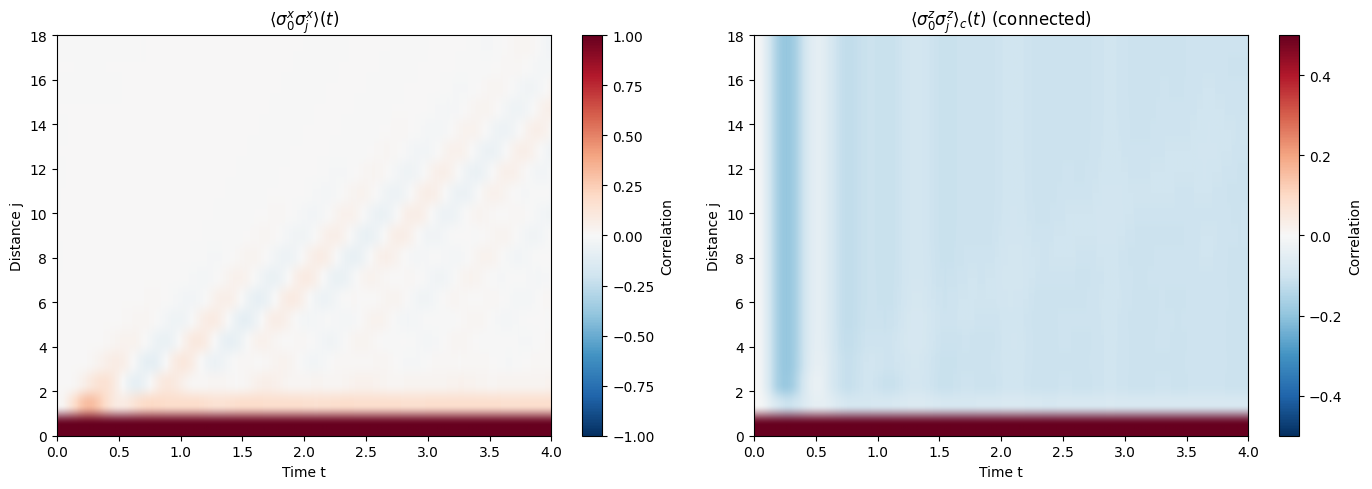

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# XX correlator heatmap
ax = axes[0]
im = ax.imshow(XX_data.T, aspect='auto', origin='lower',
               extent=[times[0], times[-1], distances[0], distances[-1]],
               cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_xlabel('Time t')
ax.set_ylabel('Distance j')
ax.set_title(r'$\langle\sigma^x_0 \sigma^x_j\rangle(t)$')
plt.colorbar(im, ax=ax, label='Correlation')

# ZZ correlator heatmap
ax = axes[1]
# For ZZ, subtract the disconnected part for better visualization
ZZ_connected = ZZ_data.copy()
for i in range(n_times):
    ZZ_connected[i, 1:] -= ZZ_data[i, 0]**2  # Subtract <σ^z>^2 for j≠0

im = ax.imshow(ZZ_connected.T, aspect='auto', origin='lower',
               extent=[times[0], times[-1], distances[0], distances[-1]],
               cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax.set_xlabel('Time t')
ax.set_ylabel('Distance j')
ax.set_title(r'$\langle\sigma^z_0 \sigma^z_j\rangle_c(t)$ (connected)')
plt.colorbar(im, ax=ax, label='Correlation')

plt.tight_layout()
plt.savefig('quench_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Line plots at fixed distances

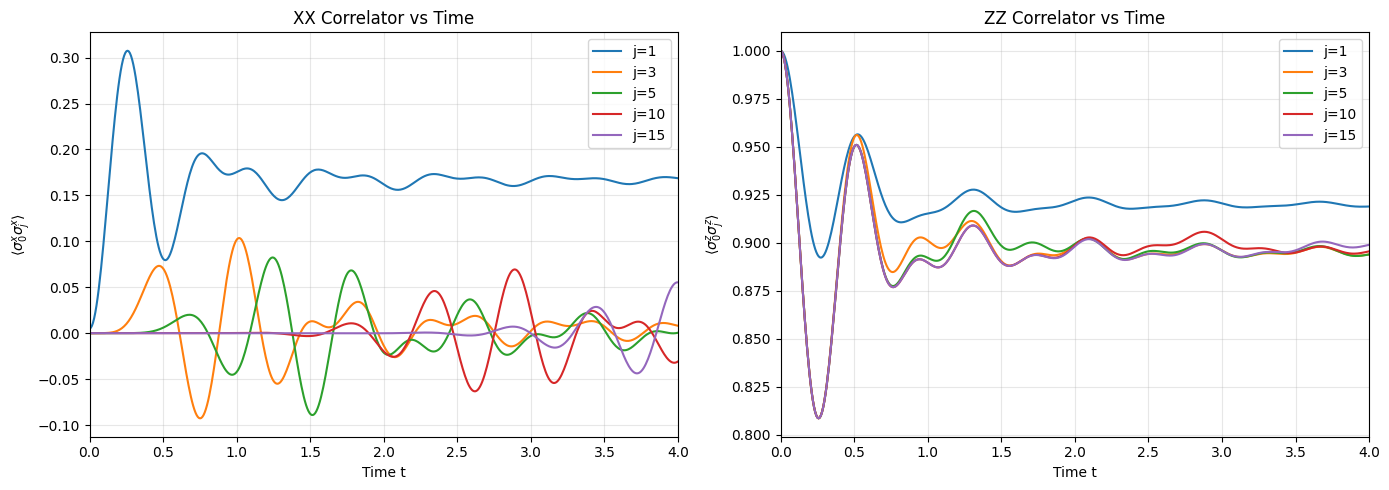

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select distances to plot
plot_distances = [1, 3, 5, 10, 15]

# XX correlator vs time
ax = axes[0]
for d in plot_distances:
    if d < len(distances):
        ax.plot(times, XX_data[:, d], label=f'j={d}')
ax.set_xlabel('Time t')
ax.set_ylabel(r'$\langle\sigma^x_0 \sigma^x_j\rangle$')
ax.set_title('XX Correlator vs Time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, t_max)

# ZZ correlator vs time
ax = axes[1]
for d in plot_distances:
    if d < len(distances):
        ax.plot(times, ZZ_data[:, d], label=f'j={d}')
ax.set_xlabel('Time t')
ax.set_ylabel(r'$\langle\sigma^z_0 \sigma^z_j\rangle$')
ax.set_title('ZZ Correlator vs Time')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, t_max)

plt.tight_layout()
plt.savefig('quench_time_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Spatial profiles at fixed times

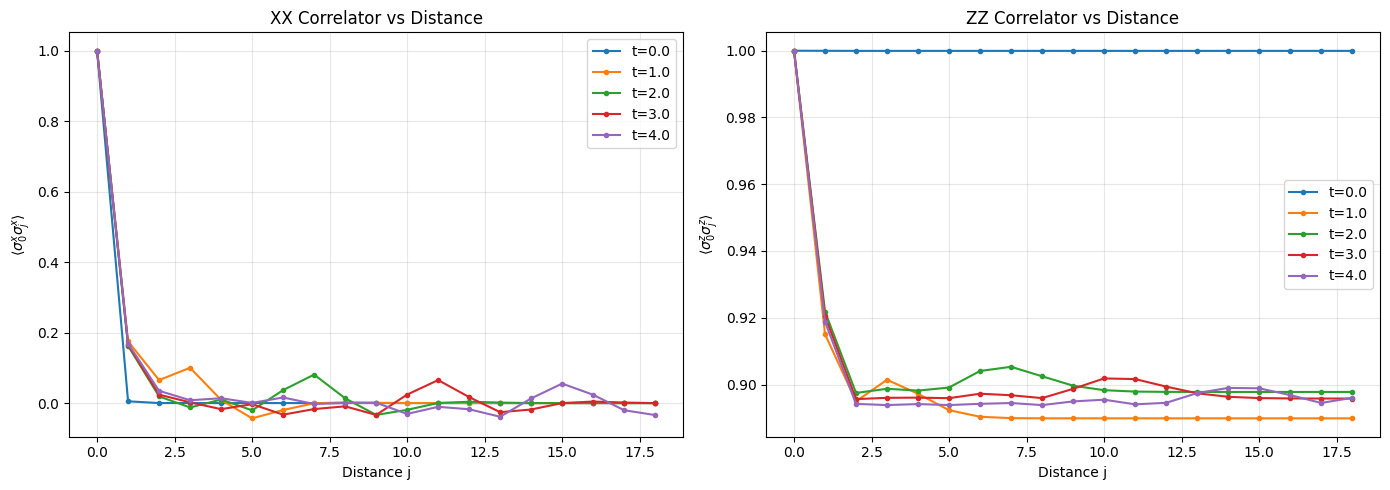

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Select times to plot
plot_times = [0.0, 1.0, 2.0, 3.0, 4.0]
time_indices = [int(t / t_max * (n_times - 1)) for t in plot_times]

# XX correlator vs distance
ax = axes[0]
for t_idx, t in zip(time_indices, plot_times):
    ax.plot(distances, XX_data[t_idx, :], 'o-', label=f't={t}', markersize=3)
ax.set_xlabel('Distance j')
ax.set_ylabel(r'$\langle\sigma^x_0 \sigma^x_j\rangle$')
ax.set_title('XX Correlator vs Distance')
ax.legend()
ax.grid(True, alpha=0.3)

# ZZ correlator vs distance
ax = axes[1]
for t_idx, t in zip(time_indices, plot_times):
    ax.plot(distances, ZZ_data[t_idx, :], 'o-', label=f't={t}', markersize=3)
ax.set_xlabel('Distance j')
ax.set_ylabel(r'$\langle\sigma^z_0 \sigma^z_j\rangle$')
ax.set_title('ZZ Correlator vs Distance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('quench_spatial_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

### 4.4 Light-cone velocity

In integrable models like the transverse-field Ising model, correlations spread with a well-defined
"light-cone" velocity determined by the maximum group velocity of quasiparticles.

In [31]:
# Estimate light-cone velocity from the dispersion relation
# ε_k = 2 * sqrt((J cos k - h)^2 + J^2 sin^2 k) for the Ising model
# The maximum group velocity is v = max |dε/dk|

k_vals = np.linspace(0, np.pi, 1000)
eps_k = 2 * np.sqrt((J * np.cos(k_vals) - h_final)**2 + J**2 * np.sin(k_vals)**2)
v_k = np.abs(np.gradient(eps_k, k_vals[1] - k_vals[0]))
v_max = np.max(v_k)

print(f"Maximum group velocity: v_max = {v_max:.4f}")
print(f"Expected light-cone slope: t/j ~ 1/v = {1/v_max:.4f}")

Maximum group velocity: v_max = 2.0000
Expected light-cone slope: t/j ~ 1/v = 0.5000


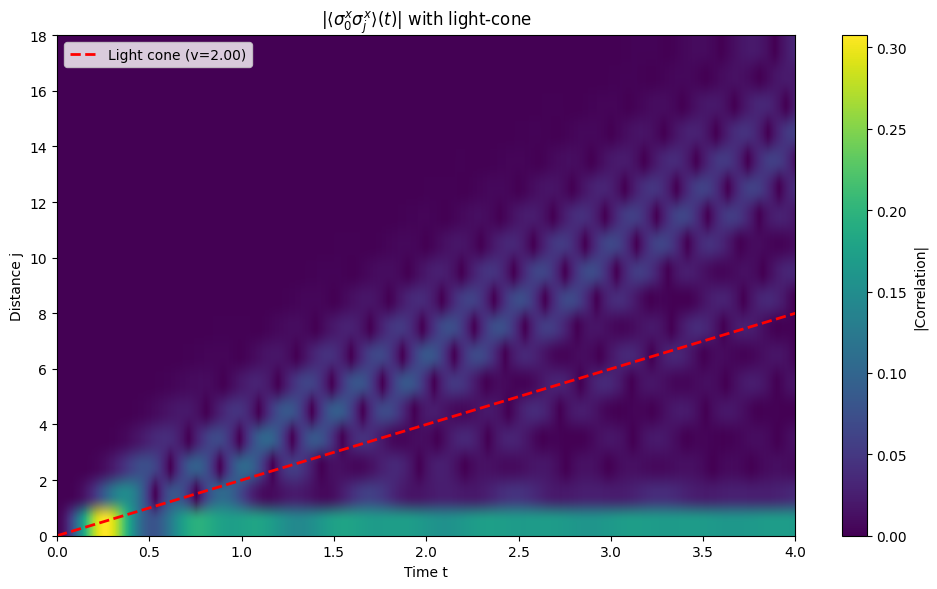

In [32]:
# Plot with light-cone overlay
fig, ax = plt.subplots(figsize=(10, 6))

# We have to skip the X0X0 correlator
im = ax.imshow(np.abs(XX_data.T)[1:,:], aspect='auto', origin='lower',
               extent=[times[0], times[-1], distances[0], distances[-1]],
               cmap='viridis')

# Overlay light-cone
t_line = np.linspace(0, t_max, 100)
j_line = v_max * t_line
ax.plot(t_line, j_line, 'r--', linewidth=2, label=f'Light cone (v={v_max:.2f})')

ax.set_xlabel('Time t')
ax.set_ylabel('Distance j')
ax.set_title(r'$|\langle\sigma^x_0 \sigma^x_j\rangle(t)|$ with light-cone')
ax.set_ylim(0, max_dist)
ax.legend(loc='upper left')
plt.colorbar(im, ax=ax, label='|Correlation|')

plt.tight_layout()
plt.savefig('quench_lightcone.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary

After the quench from h=100 to h=3:

1. **XX Correlations**: Initially zero (product state in z-basis), then build up as
   quasiparticles propagate through the system. The correlations spread ballistically
   with the light-cone velocity.

2. **ZZ Correlations**: Initially 1 everywhere (product state), then decay as entanglement
   spreads through the system. The connected correlator shows the characteristic
   light-cone spreading.

3. **Light-cone**: The maximum group velocity of the post-quench Hamiltonian determines
   how fast correlations can spread. This is a manifestation of the Lieb-Robinson bound.

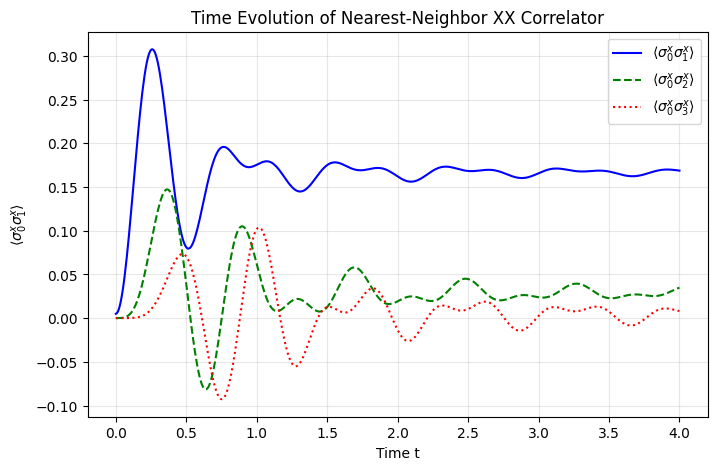

In [ ]:
# Plot the X0X1 and X0X2, X0X3 correlator over time
plt.figure(figsize=(8, 5))
plt.plot(times, XX_data[:, 1], 'b-', label=r'$\langle\sigma^x_0 \sigma^x_1\rangle$')
plt.plot(times, XX_data[:, 2], 'g--', label=r'$\langle\sigma^x_0 \sigma^x_2\rangle$')
plt.plot(times, XX_data[:, 3], 'r:', label=r'$\langle\sigma^x_0 \sigma^x_3\rangle$')
plt.xlabel('Time t')
plt.ylabel(r'$\langle\sigma^x_0 \sigma^x_1\rangle$')
plt.title('Time Evolution of Nearest-Neighbor XX Correlator')
plt.grid(True, alpha=0.3)
plt.legend()

In [ ]:
np.savez('quench_correlation_data.npz', times=times, distances=distances, XX_data=XX_data, ZZ_data=ZZ_data)vez('quench_correlation_data.npz', times=times, distances=distances,